<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/dataset2_employed/dataset2/notebooks/dataset2_SMI_SED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실제 분석 및 과정

# 통계적 차이 검정

- 숫자형 - ANOVA
- 범주형 - 카이제곱

# SMI/SED/진단없음 분석 및 SHAP

## 랜덤포레스트, XGBOOST

### 고려한 점

- (0=해당없음, 1=SMI, 2=SED)

### 앞으로 생각해볼 지점

아마도 feature들로 인해 target(SMI,SED,해당없음)으로 인과관계를 정리해볼 수는 있겠으나 이는 논문 등을 참고해서 진행해야할 것 같음.

현재 분석 결과만으로는 인과관계보다는 상관관계에 가깝다고 보아야함.

### 랜덤포레스트 결과

- 전체변수 포함: 정확도 0.76
    - 정확도는 높으나, 너무 이론적으로 당연한 결고ㅘ

```markdown
### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부
```

- 진단변수 미포함 : 정확도 0.68
    - 정확도는 조금 낮지만, 더 유의미한 설명이 가능함.
    - 코드 결과는 노션 참고
        

### XGBOOST 결과

- 전체 변수 포함 - 정확도 : 0.85
    - 정확도는 좋지만, 정신질환이 있을 때 더 심한 질환/ 증상을 가지게 된다는 것은 너무 이론적으로 당연한 이야기
- **진단 변수 미포함 - 정확도 : 0.82**
- 코드 결과는 노션참고

# 로지스틱 회귀 분석

SHAP에서 높게 나온 것들 위주로 변수를 선택하고, 그것으로 로지스틱 회귀분석을 진행함.

```markdown

클래스 0, 즉 정신질환이 없는 사람들과 비교했을 때 차이점을 확인함.

### 클래스 1 (SMI-중증 정신질환)
stateip, nummhs, employ, educ, detnlf_2, traustreflg, division_3, race_3 순서로 높게 나타남.

따라서 거주지역, 서비스의 양, 고용 혹은 교육, 인종이 크게 의미를 가진다는 것을 볼 수 있음

SHAP으로 분석한 것과 다르게 연령이 큰 영향을 미치지 않음.

### 클래스 2 (SED-심각한 정서질환)
age, nummhs, employ, educ, detnlf_2, division_8, race_3, stateip, traustreflg 기준으로 높게 나타남

따라서 청소년, 교육ㅇ 부족, 경제활동을 하지 않음, 특정 지역과 연관되어 있을 때 의미를 가짐.

연령이 유의미한 결과를 미침.
회귀분석 결과 또한 아래 결과 혹은 노션 참고

# **STEP1. 통계적 차이 검정**

In [8]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/단순결측치 행 제거.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


전체적으로 단순 결측값 데이터셋, 결측값 모두 제거한 데이터셋 두개를 돌렸을 때 SMISED와 각 FEATURE들의 관계성은 비슷하게 나타남.

In [9]:
# 단순결측치 행 제거로 돌린 통계적 차이 검정

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)


ANOVA for AGE
                  sum_sq         df             F  PR(>F)
C(SMISED)  213562.163671        2.0  1.939641e+06     0.0
Residual   292744.796399  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.5389   0.0 -0.5395 -0.5382   True
     1      3  -0.1577   0.0 -0.1583 -0.1572   True
     2      3   0.3811   0.0  0.3804  0.3819   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)  4.698579e+05        2.0  10263.551572     0.0
Residual   1.217181e+08  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.7943   0.0 -0.8074 -0.7812   True
     1      3  -0.1142   0.0 -0.

**AGE**	1 < 2 < 3	SMISED 높을수록 나이 증가

**EDUC** 	3번 그룹(중증)의 교육 수준 매우 낮음

**NUMMHS**	서비스 많이 이용한 그룹들이 있어보이나, 그렇게 연관성이 커보이지는 않음

**ETHNIC** 인종/민족으로 차이가 있어보임

**RACE** 인종

**GENDER** 남/녀 비율 다름

**SPHSERVICE** SMISED가 높을수록 이용 증가

**CMPSERVICE**	일부 그룹만 이용

**OPISERVICE**	외래 서비스 차이 큼	접근성 or 서비스 패턴 차이

**RTCSERVICE** 조금 약한데, 그래도 차이 있어보임

**SUB (Substance Use)**	정신질환과 약물 사용 연관성 있음

**MARSTAT (결혼상태)** 미혼 or 이혼 그룹에서 많음

**EMPLOY**	무직 비율이 높음

          SMISED가 높을수록 고용률 낮음

**DETNLF**	경제활동 인구나 노동 참여 관련

**VETERAN**	 군복무 경험 여부

**LIVARAG** 동거 여부

**DIVISION** 지역 간 분포 다름
          
          얘 또한 지역별 차이로, 정책이나 지원을 반영했거나
          우리의 전처리 과정에서의 차이일 수 있을 것

**REGION**	북동/남부 등 차이 존재

          이것 또한 결측치 많은 지역들이 삭제되어 데이터 전체에 영향을 주었을 기능성이 있어 보임

**STATEFIP**	주별 분포 다름	데이터 구조상 영향 큼

          주별로 결측치가 많은 주가 삭제되어서 그런지, 데이터 자체의 차이가 큰 것 같음.
          + 변수 개수 많아 원핫 주의


In [10]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [11]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/drive')

# 1. 데이터 불러오기
file_path = '/content/drive/MyDrive/결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [13]:
# 모든 결측치 제거한 데이터셋 활용 분석

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)



ANOVA for AGE
                 sum_sq         df             F  PR(>F)
C(SMISED)   7627.331877        2.0  77138.201968     0.0
Residual   56745.448452  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.4482   0.0  -0.451 -0.4453   True
     1      3  -0.0824   0.0 -0.0835 -0.0812   True
     2      3   0.3658   0.0  0.3628  0.3687   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)   2947.253697        2.0  28502.441533     0.0
Residual   59342.161098  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.2702   0.0 -0.2731 -0.2673   True
     1      3  -0.0593   0.0 -0.060

# **STEP2~3. SMI/SED/진단 없음 트리기반 분석 및 SHAP**

 (0=해당없음, 1=SMI, 2=SED)

In [61]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

In [62]:

pd.set_option('display.max_columns', None)
df.head(10)

,YEAR,AGE,EDUC,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,MH1,MH2,MH3,SAP,EMPLOY,VETERAN,NUMMHS,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,CASEID,RACE_2,RACE_3,RACE_4,RACE_5,RACE_6,ETHNIC_2,ETHNIC_3,ETHNIC_4,REGION_1,REGION_2,REGION_3,REGION_4,SUB_1,SUB_2,SUB_3,SUB_4,SUB_5,SUB_6,SUB_7,SUB_8,SUB_9,SUB_10,SUB_11,SUB_12,SUB_13,MARSTAT_2,MARSTAT_3,MARSTAT_4,SMISED_2,SMISED_3,DETNLF_2,DETNLF_3,DETNLF_4,DETNLF_5,DETNLF_NotApplicable,LIVARAG_2,LIVARAG_3,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9
0,2022,0.461538,0.50,1,0,1,0,0,0,7,11,-99,1,0.25,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,20220000002,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
1,2022,1.000000,0.75,0,1,1,0,0,0,11,-99,-99,2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20220000004,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
2,2022,0.615385,1.00,0,0,1,1,0,0,7,1,2,1,0.00,0,3,1,1,0,0,0,0,1,0,0,0,0,0,0,1,20220000013,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,2022,0.615385,1.00,0,0,1,1,0,0,7,-99,-99,2,1.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000025,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
4,2022,0.846154,0.50,0,0,1,0,0,0,6,-99,-99,1,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000029,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
5,2022,0.538462,0.50,1,0,1,0,0,0,6,13,-99,1,0.00,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,1,20220000031,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
6,2022,0.461538,1.00,0,0,1,0,0,0,2,-99,-99,2,1.00,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,20220000033,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
7,2022,0.692308,0.75,0,0,1,0,0,0,7,-99,-99,2,0.25,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000034,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
8,2022,0.384615,0.75,1,0,1,0,0,0,6,-99,-99,2,1.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000038,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
9,2022,0.846154,0.75,0,0,1,1,0,0,11,-99,-99,2,0.25,0,1,0,0,0,0,0,0,0

In [63]:
print(df.columns.tolist())

['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'EMPLOY', 'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2', 'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9']


### **Random Forest 기반, 모든 변수 포함**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.7623


PermutationExplainer explainer: 301it [00:59,  4.50it/s]


None


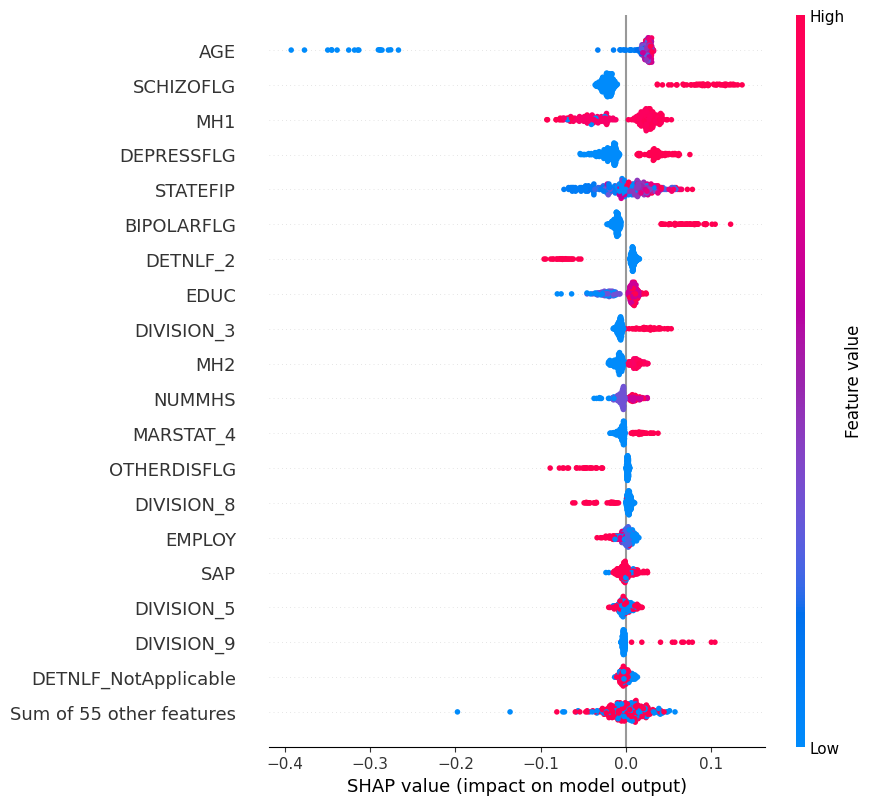

SMI


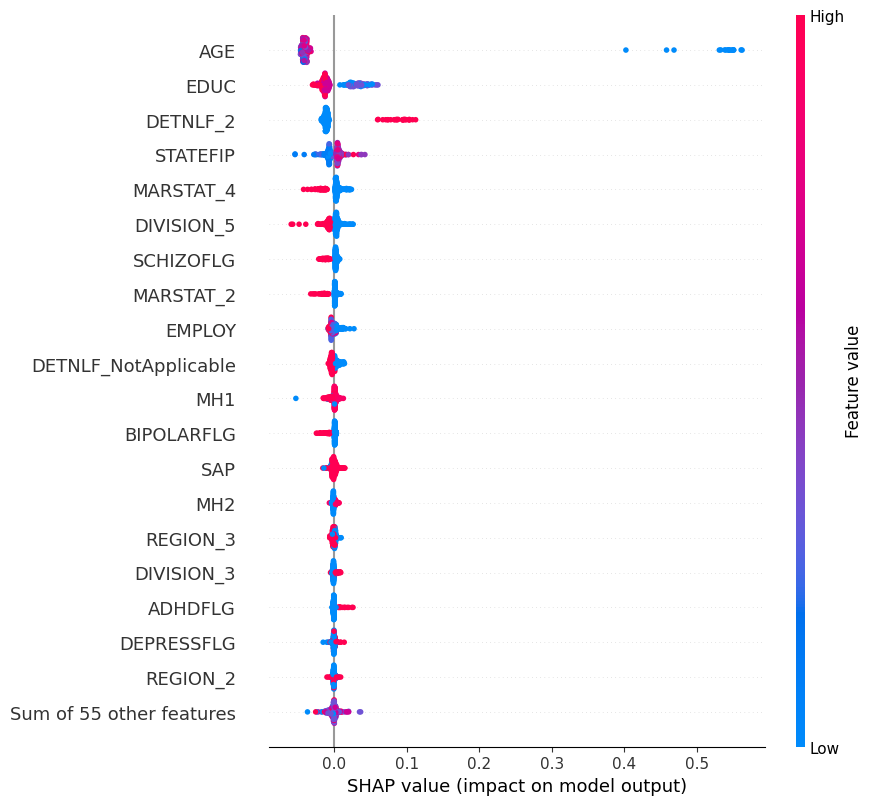

SED


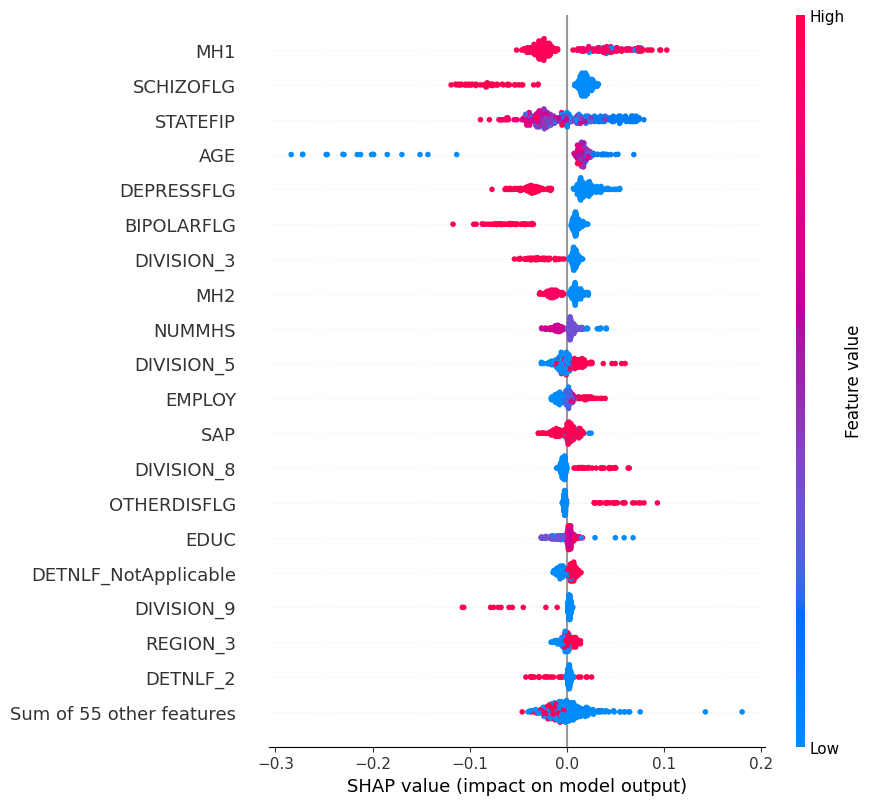

In [19]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# SMISED 타겟 컬럼 생성 (0=해당없음, 1=SMI, 2=SED)
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0), axis=1)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype(float)

# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)

# 시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.90      0.78      0.84    838304
         SMI       0.67      1.00      0.80     35078
         SED       0.50      0.66      0.57    274399

    accuracy                           0.76   1147781
   macro avg       0.69      0.82      0.74   1147781
weighted avg       0.80      0.76      0.77   1147781



In [21]:
# 클래스0 증상 없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df4 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df4.abs().mean().sort_values(ascending=False)
importance.head(10)

,0
AGE,0.040997
SCHIZOFLG,0.034595
MH1,0.033798
DEPRESSFLG,0.026036
STATEFIP,0.024535
BIPOLARFLG,0.021082
DETNLF_2,0.014352
EDUC,0.014205
DIVISION_3,0.011499
MH2,0.010097


In [22]:
# 클래스1 SMI SHAP 값
shap_values_class1 = shap_values[:, :, 1].values

df2 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df2.abs().mean().sort_values(ascending=False)
print(importance.head(10))


AGE                     0.068734
EDUC                    0.019250
DETNLF_2                0.017580
STATEFIP                0.008144
MARSTAT_4               0.007231
DIVISION_5              0.006549
SCHIZOFLG               0.004459
MARSTAT_2               0.003765
EMPLOY                  0.003616
DETNLF_NotApplicable    0.003385
dtype: float64


In [23]:
# 클래스2 SED SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

MH1           0.033356
SCHIZOFLG     0.030138
STATEFIP      0.029867
AGE           0.028158
DEPRESSFLG    0.026647
BIPOLARFLG    0.018293
DIVISION_3    0.012692
MH2           0.011556
NUMMHS        0.008627
DIVISION_5    0.008579
dtype: float64


### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부

### **진단 관련 변수 미포함**

Accuracy: 0.7140


PermutationExplainer explainer: 301it [00:57,  4.29it/s]


None


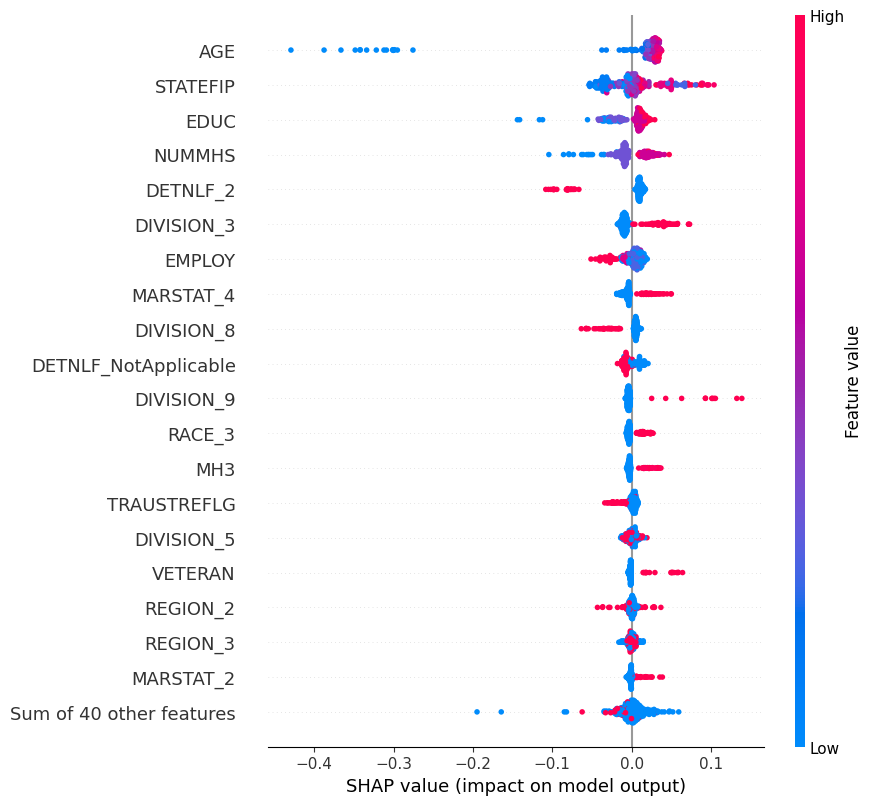

SMI


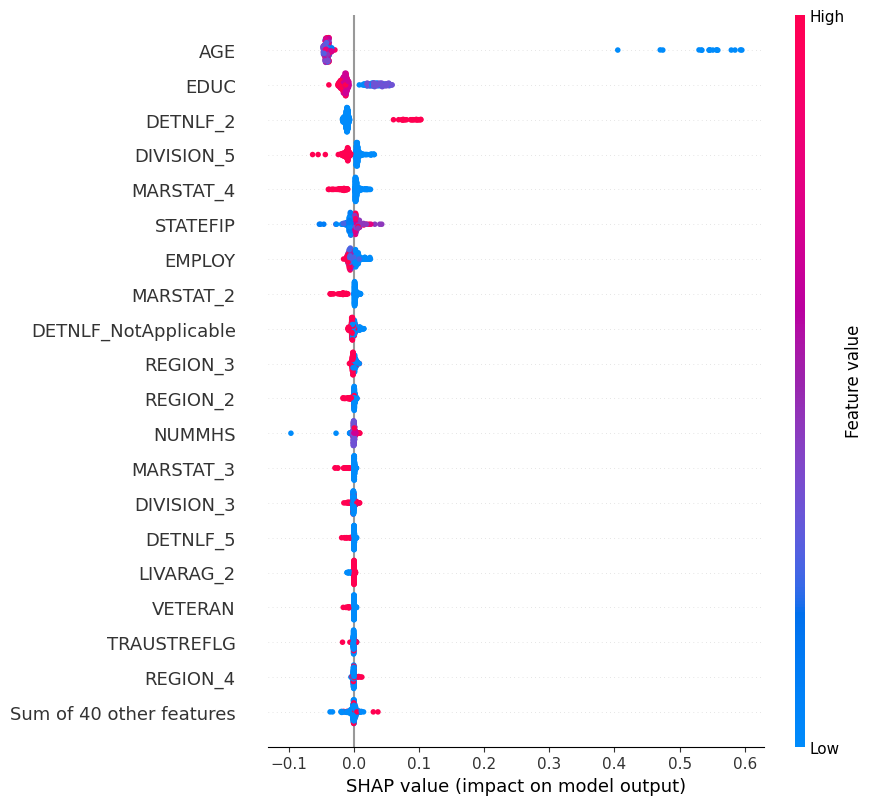

SED


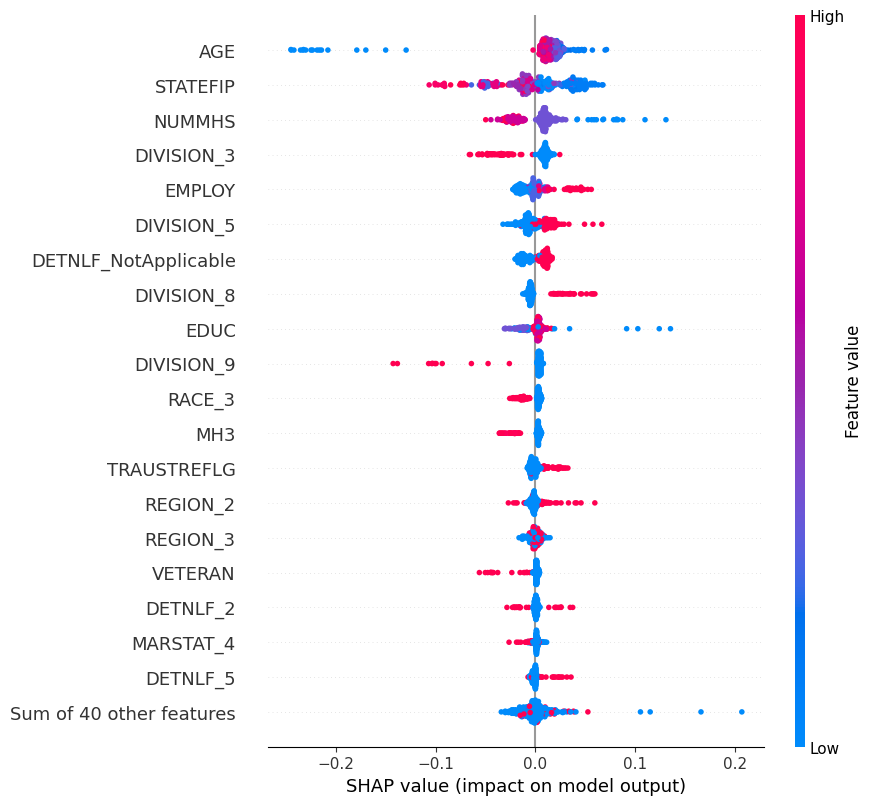

In [24]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)


# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.88      0.74      0.80    838304
         SMI       0.65      1.00      0.79     35078
         SED       0.43      0.61      0.50    274399

    accuracy                           0.71   1147781
   macro avg       0.65      0.78      0.70   1147781
weighted avg       0.76      0.71      0.73   1147781



In [26]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.042632
STATEFIP                0.023880
EDUC                    0.017103
NUMMHS                  0.016810
DETNLF_2                0.016633
DIVISION_3              0.015349
EMPLOY                  0.009916
MARSTAT_4               0.009478
DIVISION_8              0.008507
DETNLF_NotApplicable    0.007640
dtype: float64


In [27]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.069902
EDUC                    0.021049
DETNLF_2                0.017510
DIVISION_5              0.008911
MARSTAT_4               0.007582
STATEFIP                0.006113
EMPLOY                  0.006021
MARSTAT_2               0.004605
DETNLF_NotApplicable    0.003243
REGION_3                0.001946
dtype: float64


In [28]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.028087
STATEFIP                0.027862
NUMMHS                  0.018098
DIVISION_3              0.015747
EMPLOY                  0.011598
DIVISION_5              0.010449
DETNLF_NotApplicable    0.009792
DIVISION_8              0.008311
EDUC                    0.007924
DIVISION_9              0.007385
dtype: float64


### 클래스0 (정신장애 없음)



### 클래스 0
AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

### 클래스1 (SMI)
AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

### 클래스 2 (SED)
NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3

AGE(청소ㅕㄴ층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### **지역변수도 함께 제거**

상위 5개만 가지고 확인 중인데, 모두 질환제거했을 때와 항목은 동일

In [29]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

Accuracy: 0.6800


PermutationExplainer explainer: 301it [01:07,  3.77it/s]


None


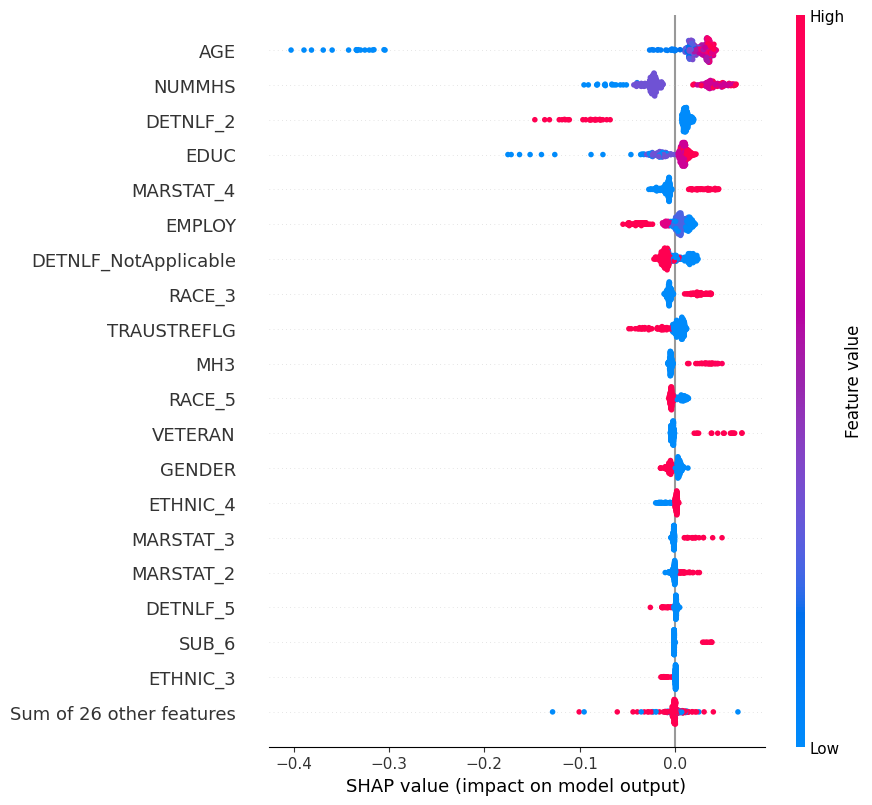

SMI


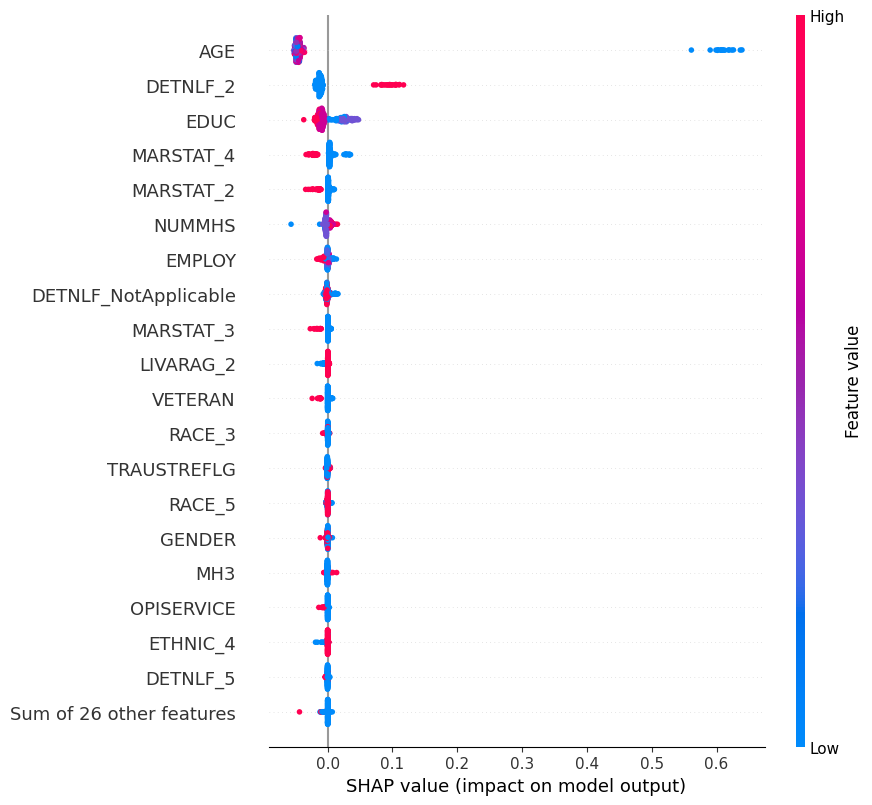

SED


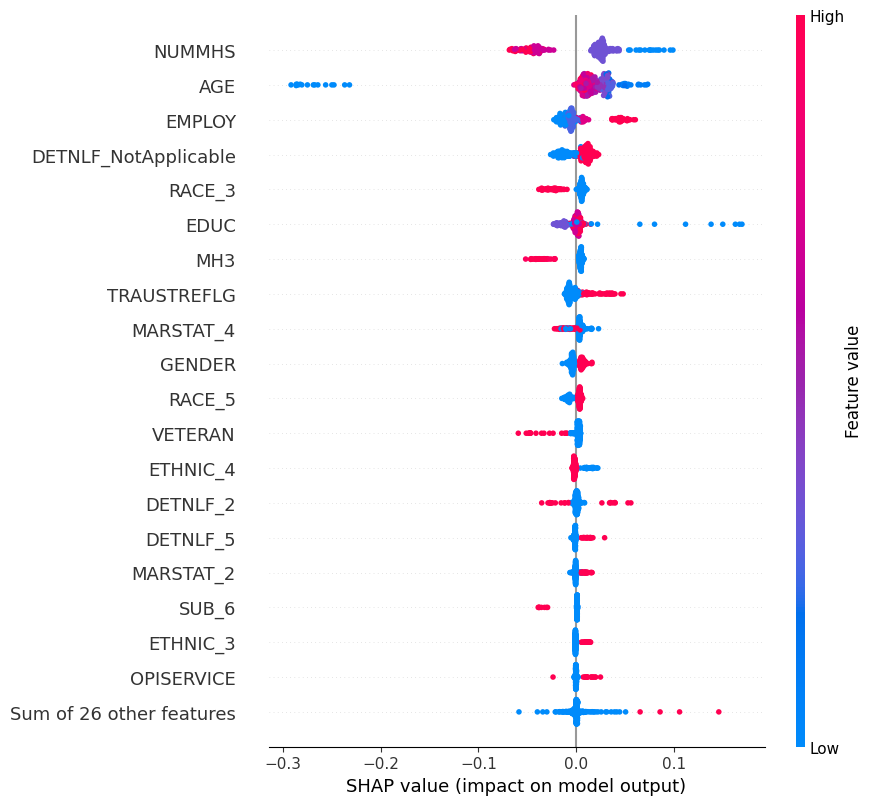

In [30]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 지역 변수도 추가로 제거
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 지역 변수 제거 이후 X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)
# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# 11. SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 14. 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [31]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.044031
NUMMHS                  0.032816
DETNLF_2                0.019130
EDUC                    0.015435
MARSTAT_4               0.012646
EMPLOY                  0.012445
DETNLF_NotApplicable    0.010906
RACE_3                  0.010511
TRAUSTREFLG             0.008433
MH3                     0.007927
dtype: float64


In [32]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.078170
DETNLF_2                0.019317
EDUC                    0.015744
MARSTAT_4               0.008422
MARSTAT_2               0.003908
NUMMHS                  0.003214
EMPLOY                  0.002370
DETNLF_NotApplicable    0.002239
MARSTAT_3               0.001972
LIVARAG_2               0.001323
dtype: float64


In [33]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

NUMMHS                  0.035943
AGE                     0.035195
EMPLOY                  0.013672
DETNLF_NotApplicable    0.011323
RACE_3                  0.009872
EDUC                    0.008591
MH3                     0.008229
TRAUSTREFLG             0.008093
MARSTAT_4               0.005425
GENDER                  0.005215
dtype: float64


### **클래스 0 (해당 없음)**
**AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4**

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

---

### **클래스1 (SMI)**
**AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2**

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

---

### **클래스 2 (SED)**
**NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3**

AGE(청소년층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### **XGBOOST : 모든 변수 포함**


랜덤포레스트와의 정확도 비교 위하여 XGBOOST행

In [69]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:07:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8494


In [70]:
print(type(shap_values))
print(len(shap_values))           # 클래스 개수?
print(shap_values[0].shape)       # 클래스 0에 대한 SHAP 값 shape
print(X_sample.shape)             # 피처 샘플 shape


<class 'numpy.ndarray'>
300
(59, 3)
(300, 59)



클래스 0 (None)


/tmp/ipython-input-71-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


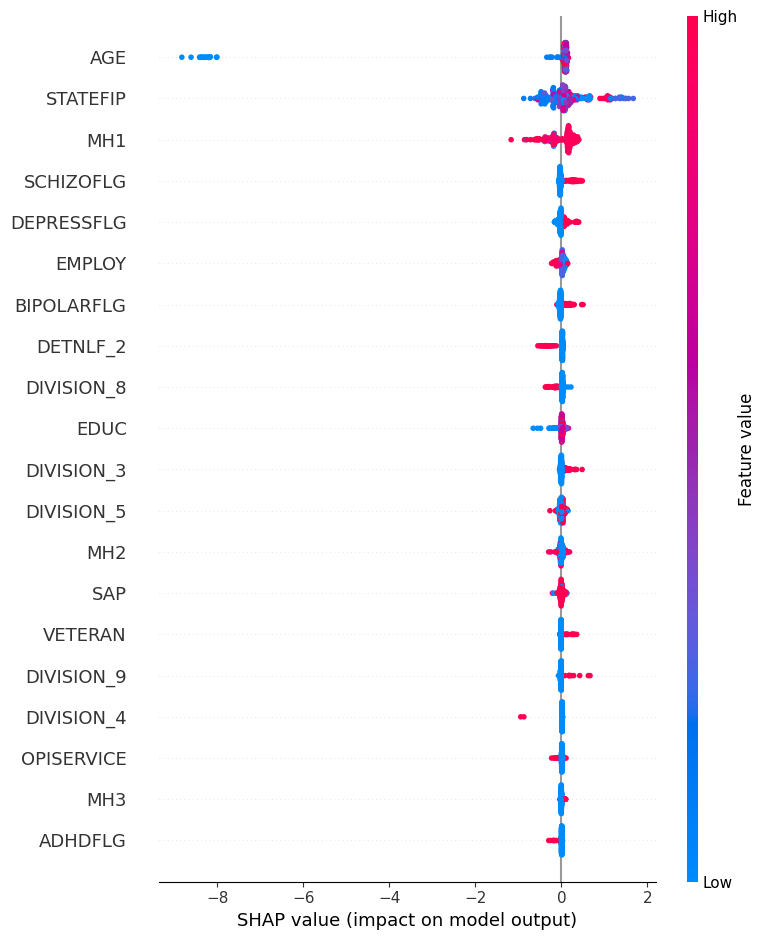


클래스 1 (SMI)


/tmp/ipython-input-71-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


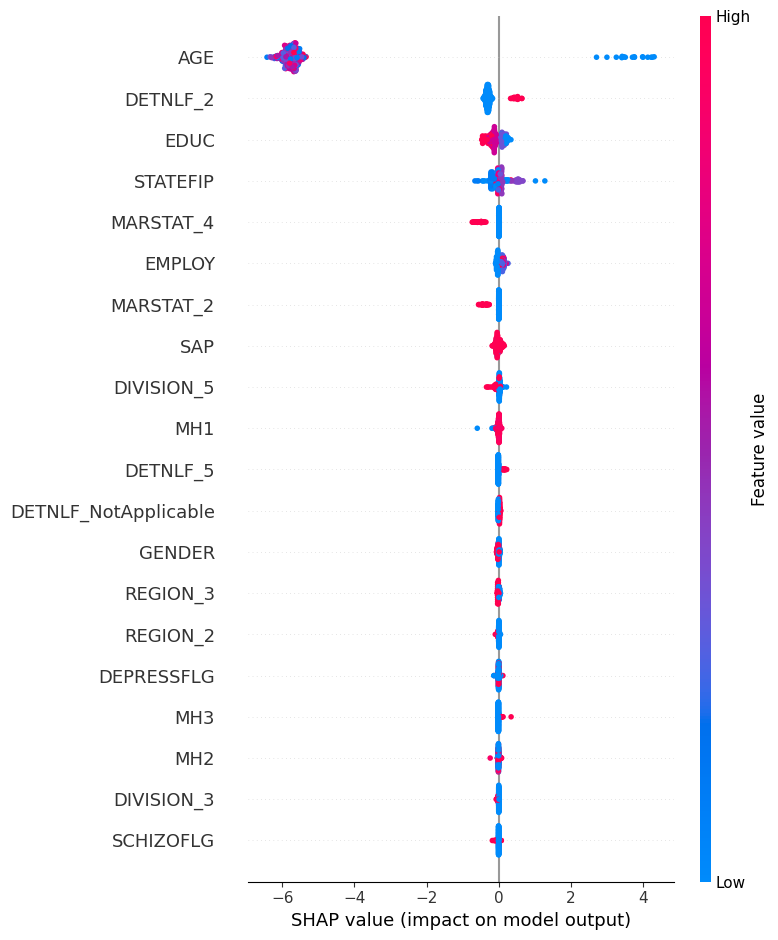


클래스 2 (SED)


/tmp/ipython-input-71-1764749090.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


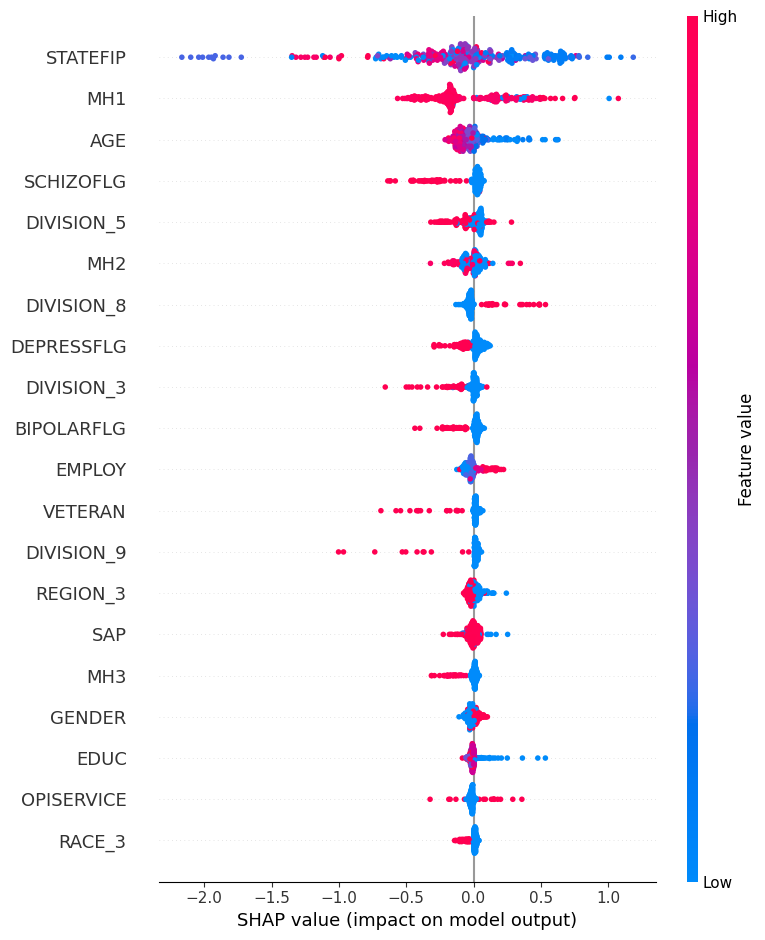

In [71]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  # 3 classes: 0=None, 1=SMI, 2=SED
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]

    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [72]:
print((X_sample.size))

22200


In [73]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           0.570559
STATEFIP      0.293030
MH1           0.230329
SCHIZOFLG     0.069946
DEPRESSFLG    0.054661
EMPLOY        0.052685
BIPOLARFLG    0.050195
DETNLF_2      0.045879
DIVISION_8    0.041741
EDUC          0.037737
dtype: float32


In [74]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

AGE           5.648525
DETNLF_2      0.313364
EDUC          0.179782
STATEFIP      0.138999
MARSTAT_4     0.100917
EMPLOY        0.076296
MARSTAT_2     0.063513
SAP           0.051864
DIVISION_5    0.044346
MH1           0.022959
dtype: float32


In [75]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP      0.403794
MH1           0.253603
AGE           0.088795
SCHIZOFLG     0.084895
DIVISION_5    0.060868
MH2           0.055018
DIVISION_8    0.052614
DEPRESSFLG    0.051533
DIVISION_3    0.047415
BIPOLARFLG    0.045978
dtype: float32


### 진단 미포함

In [76]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:09:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8212


<class 'numpy.ndarray'>
300
(59, 3)
(300, 59)

클래스 0 (None)


/tmp/ipython-input-77-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


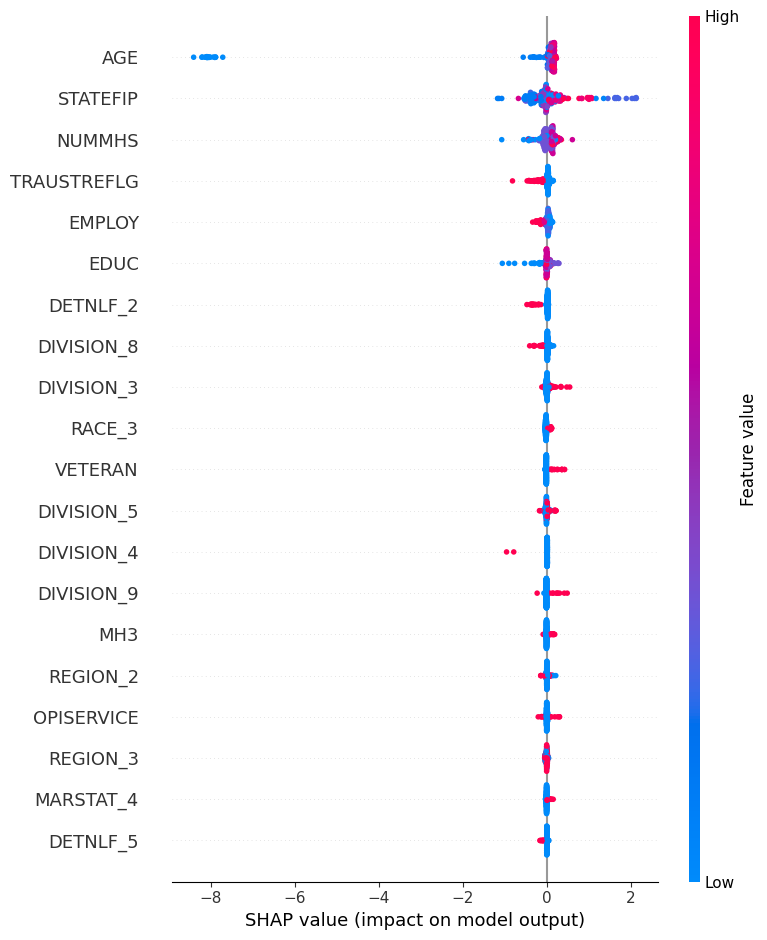


클래스 1 (SMI)


/tmp/ipython-input-77-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


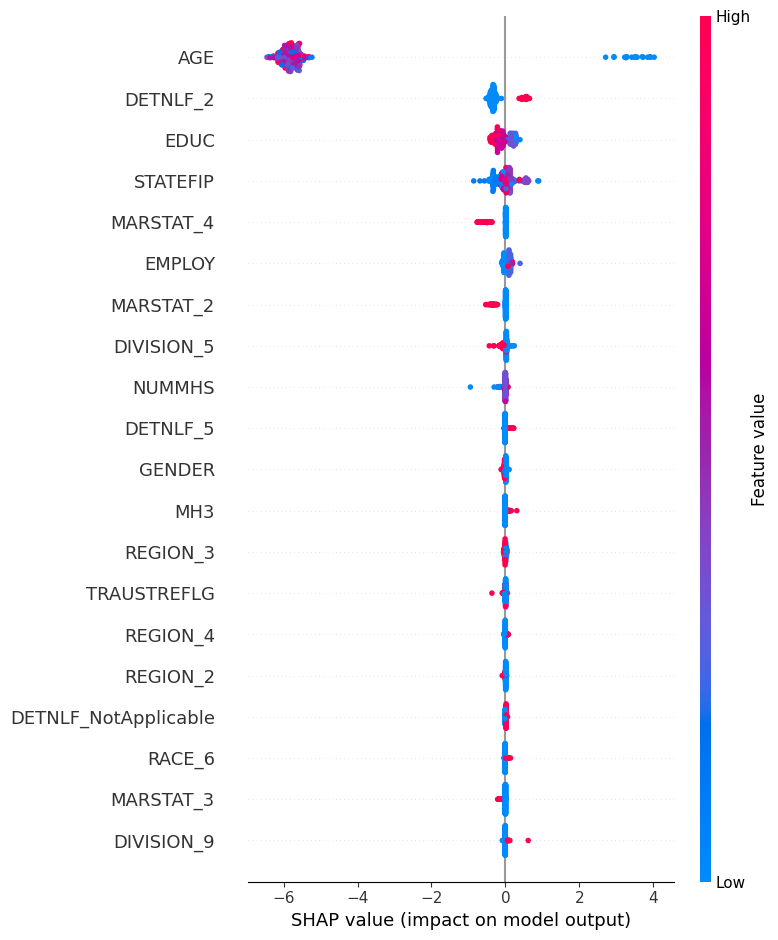


클래스 2 (SED)


/tmp/ipython-input-77-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


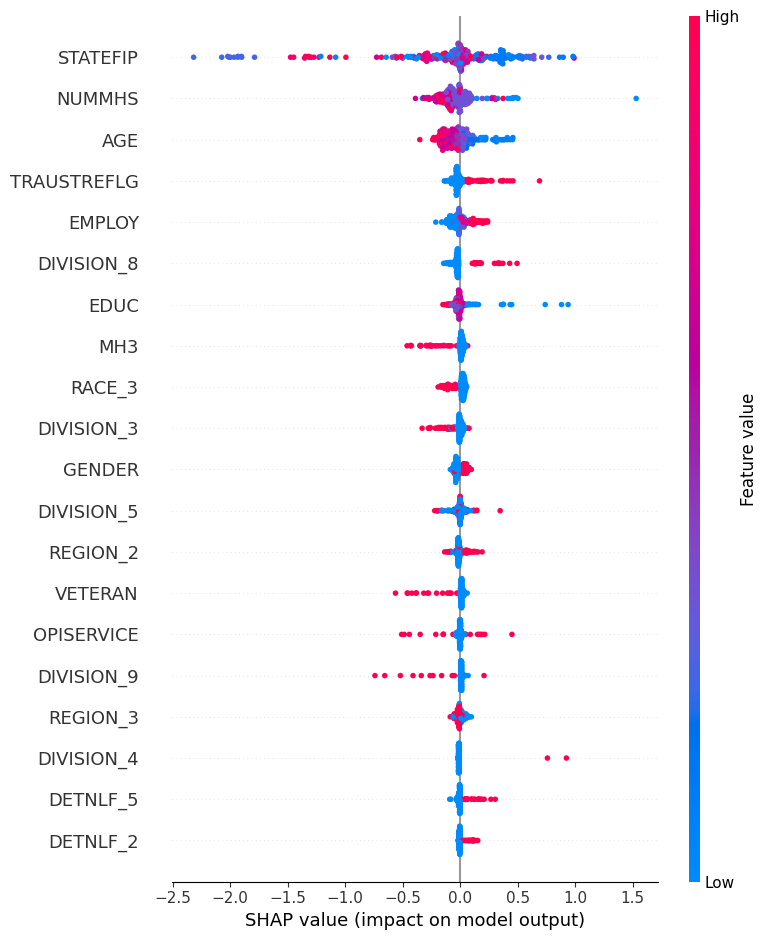

In [77]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [78]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE            0.573851
STATEFIP       0.287913
NUMMHS         0.121157
TRAUSTREFLG    0.066687
EMPLOY         0.060860
EDUC           0.056033
DETNLF_2       0.042781
DIVISION_8     0.041214
DIVISION_3     0.034355
RACE_3         0.028349
dtype: float32


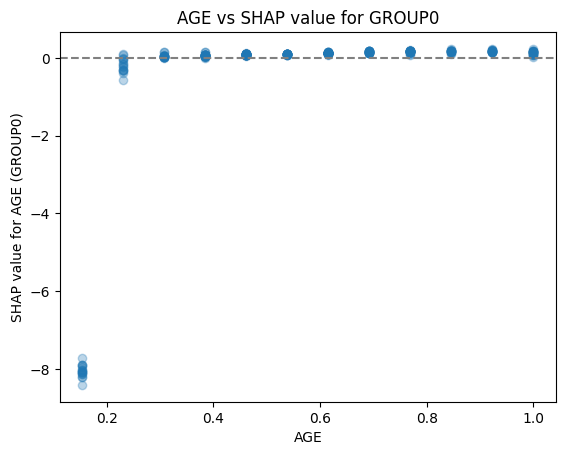

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


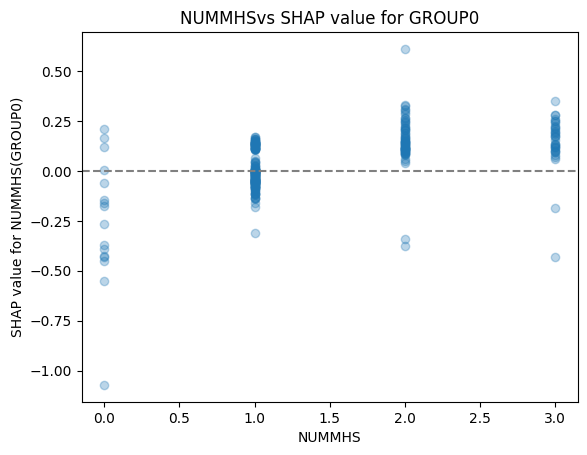

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS(GROUP0)")
plt.title("NUMMHSvs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


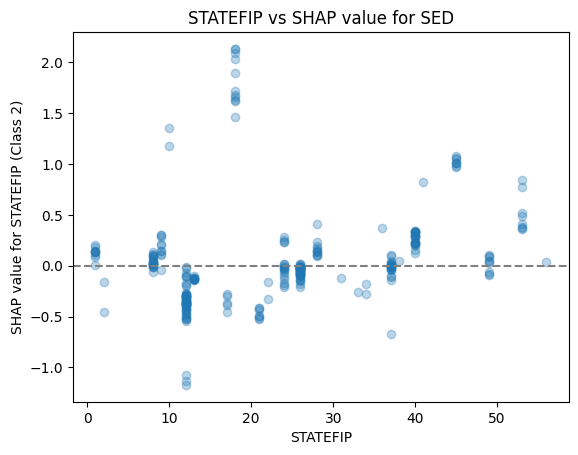

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [82]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE           5.684216
DETNLF_2      0.356444
EDUC          0.184529
STATEFIP      0.174430
MARSTAT_4     0.104269
EMPLOY        0.082074
MARSTAT_2     0.058776
DIVISION_5    0.051195
NUMMHS        0.021701
DETNLF_5      0.021205
dtype: float32


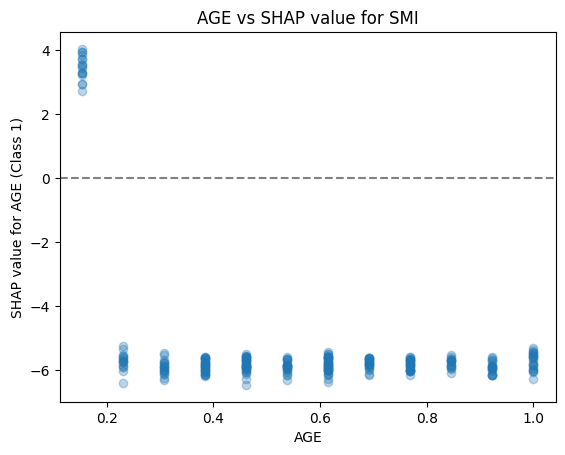

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


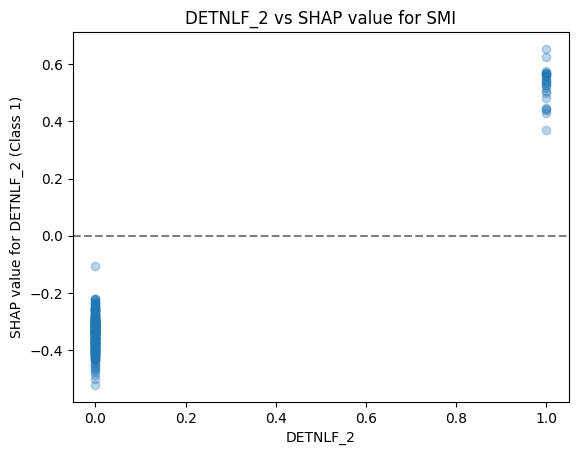

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [85]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

STATEFIP       0.340181
NUMMHS         0.104810
AGE            0.104746
TRAUSTREFLG    0.060142
EMPLOY         0.056771
DIVISION_8     0.054160
EDUC           0.042354
MH3            0.038550
RACE_3         0.037912
DIVISION_3     0.036938
dtype: float32


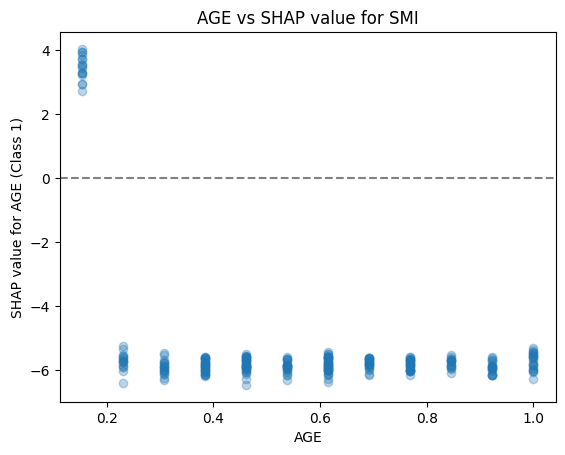

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


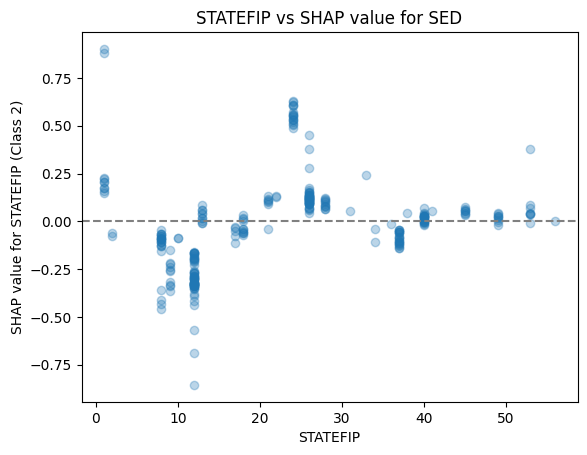

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


### 진단+지역변수 미포함

In [88]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

In [89]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7803


<class 'numpy.ndarray'>
300
(45, 3)
(300, 45)

클래스 0 (None)


/tmp/ipython-input-90-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


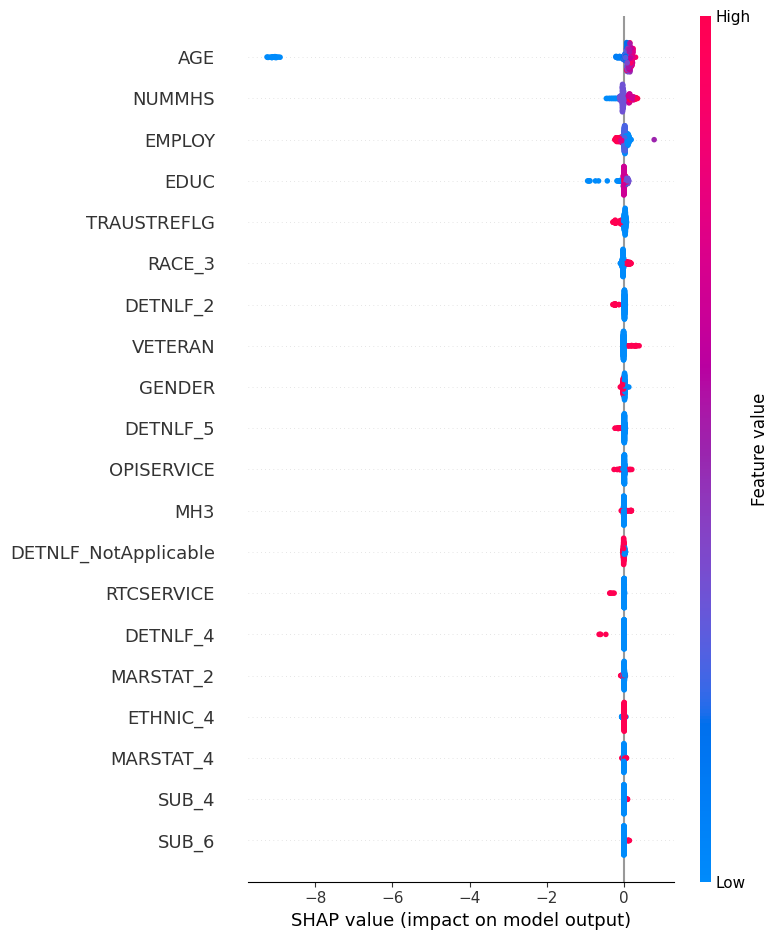


클래스 1 (SMI)


/tmp/ipython-input-90-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


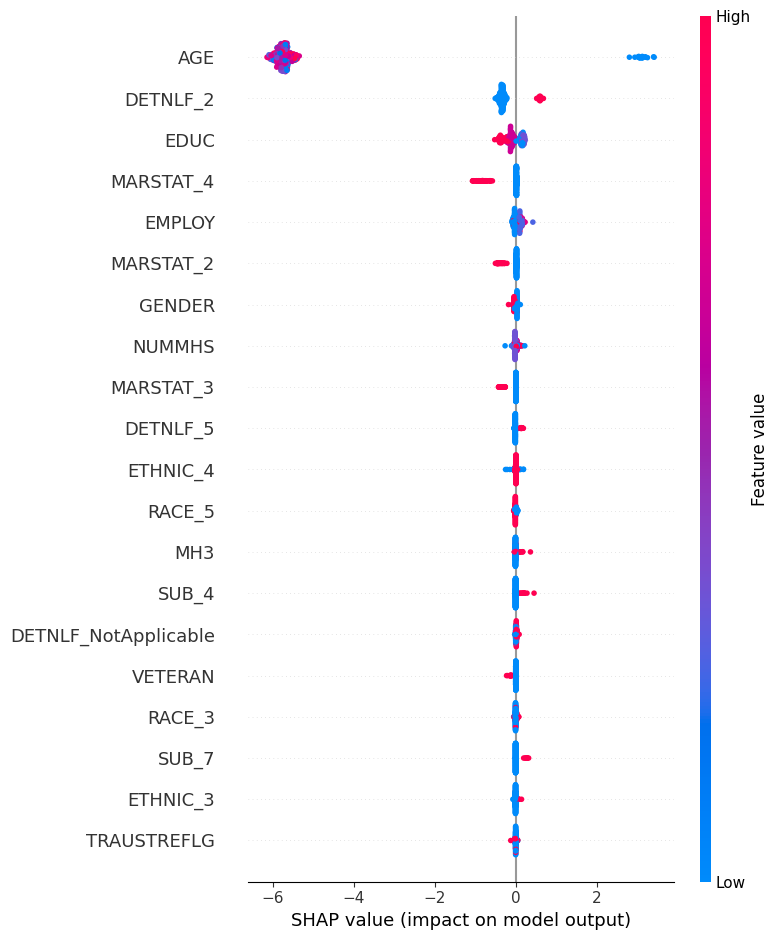


클래스 2 (SED)


/tmp/ipython-input-90-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


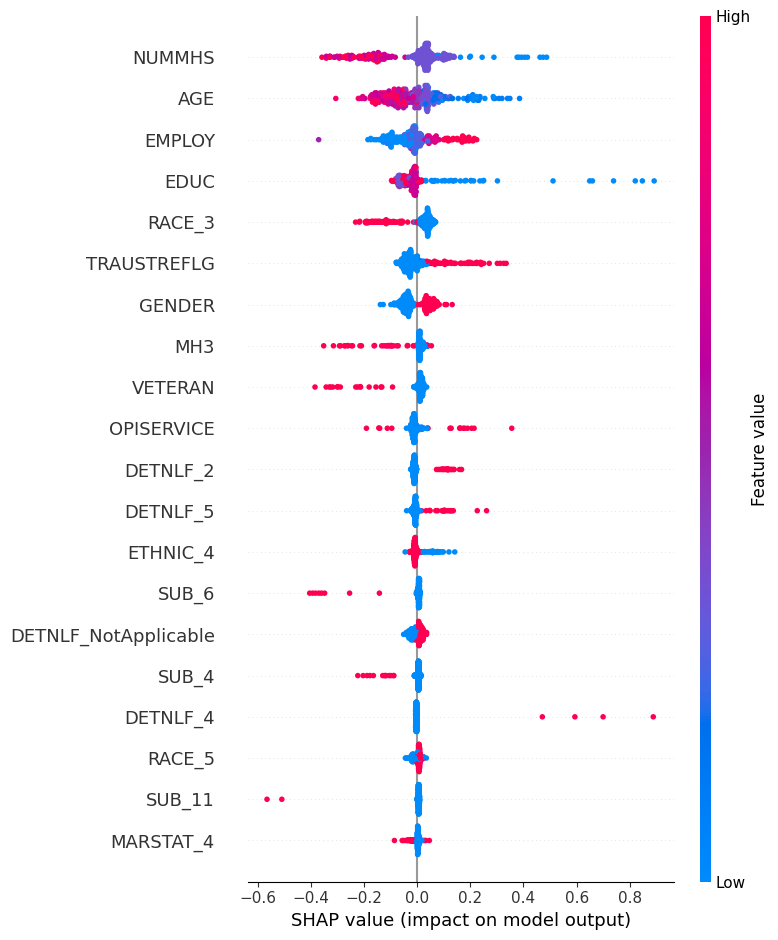

In [90]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [91]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE            0.636625
NUMMHS         0.096855
EMPLOY         0.069176
EDUC           0.051895
TRAUSTREFLG    0.048473
RACE_3         0.043733
DETNLF_2       0.031140
VETERAN        0.025669
GENDER         0.022009
DETNLF_5       0.020917
dtype: float32


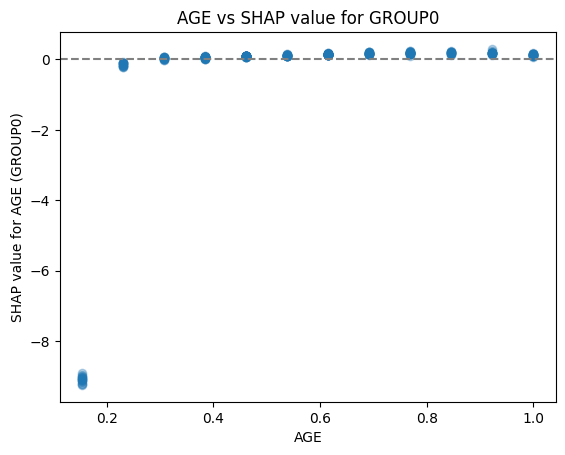

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


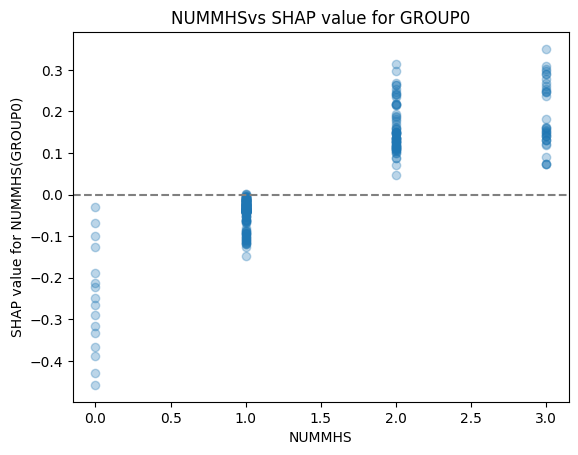

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS(GROUP0)")
plt.title("NUMMHSvs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [96]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


AGE          5.595468
DETNLF_2     0.364174
EDUC         0.172783
MARSTAT_4    0.158216
EMPLOY       0.078819
MARSTAT_2    0.067954
GENDER       0.027728
NUMMHS       0.027131
MARSTAT_3    0.026970
DETNLF_5     0.023202
dtype: float32


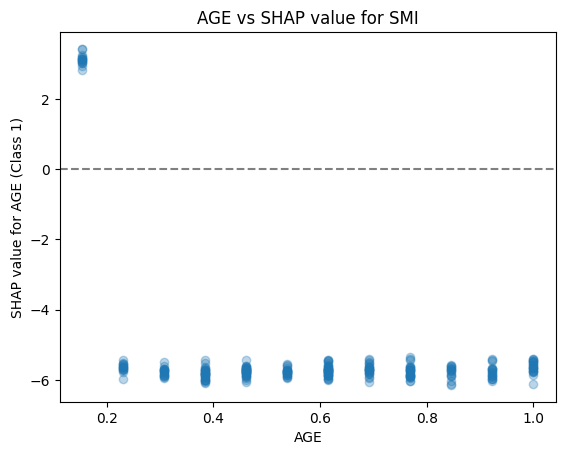

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


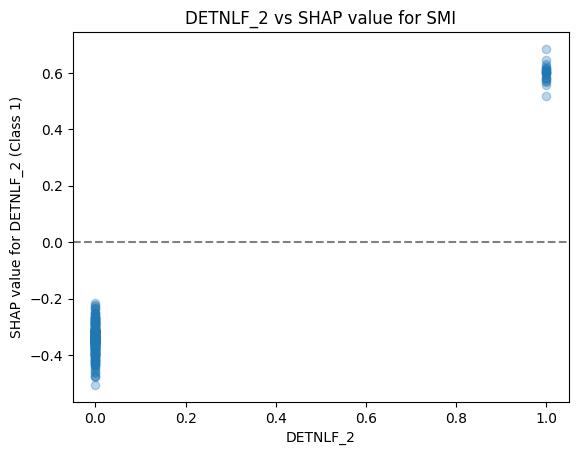

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [99]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

NUMMHS         0.111601
AGE            0.087355
EMPLOY         0.064194
EDUC           0.057518
RACE_3         0.055821
TRAUSTREFLG    0.052288
GENDER         0.046301
MH3            0.029134
VETERAN        0.026600
OPISERVICE     0.020690
dtype: float32


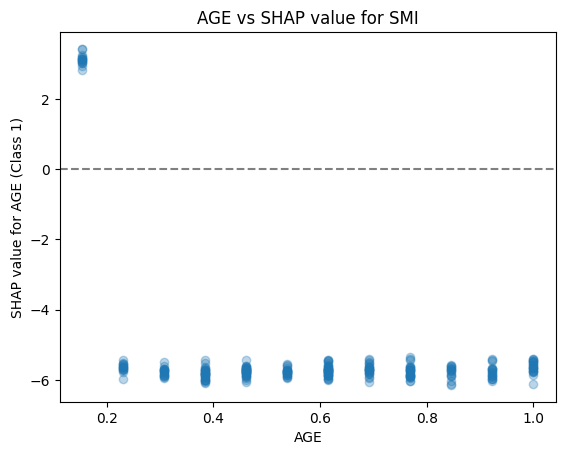

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


# **STEP4. 로지스틱 회귀분석**

위에서 분석한 결과 유의미한 변수들만을 가지고 분석을 진행함.

정신질환이 없을 때를 기준으로 중증정신질환과 심각한 정서장애, 2가지에 대해 로그 오즈 변화량을 나타냄.

### 클래스 1
stateip, nummhs, employ, educ, detnlf_2, traustreflg, division_3, race_3 순서로 높게 나타남.

따라서 거주지역, 서비스의 양, 고용 혹은 교육, 인종이 크게 의미를 가진다는 것을 볼 수 있음

SHAP으로 분석한 것과 다르게 연령이 큰 영향을 미치지 않음.

### 클래스 2
age, nummhs, employ, educ, detnlf_2, division_8, race_3, stateip, traustreflg 기준으로 높게 나타남

따라서 청소년, 교육ㅇ 부족, 경제활동을 하지 않음, 특정 지역과 연관되어 있을 때 의미를 가짐.

연령이 유의미한 결과를 미침.



In [102]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]

diagnosis_vars = [
    'MH1', 'MH2', 'MH3', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"] + diagnosis_vars, errors='ignore')

# shap 결과 반영. 주요 변수만
selected_vars = [
    'AGE', 'STATEFIP', 'NUMMHS', 'TRAUSTREFLG', 'EMPLOY',
    'EDUC', 'DETNLF_2', 'DIVISION_8', 'DIVISION_3', 'RACE_3'
]
X = X[selected_vars]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=selected_vars)
X_scaled = sm.add_constant(X_scaled)

# 로지스틱 회
model = sm.MNLogit(y, X_scaled)
result = model.fit()

# 결과 출력
print(result.summary())


KeyError: "['STATEFIP', 'DIVISION_8', 'DIVISION_3'] not in index"

# **STEP5. Clustering**

shap 결과 바탕으로 클러스터링을 준비하고 클러스터링 진행.

In [103]:
import numpy as np
import pandas as pd

shap_matrix = shap_values[:, :, 1]
print(shap_matrix.shape)


(300, 45)


In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)


In [105]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(shap_matrix_scaled)

# 클러스터 결과를 원본 샘플에
X_sample_clustered = X_sample.copy()
X_sample_clustered["Cluster"] = clusters


In [106]:
# 클러스터별 평균 SHAP
cluster_means = pd.DataFrame(shap_matrix).groupby(clusters).mean()
print(cluster_means.T)


           0         1         2
0   0.000000  0.000000  0.000000
1  -5.228960 -5.685705 -6.057397
2  -0.077910  0.175630 -0.248934
3  -0.001432  0.019116  0.062638
4  -0.001140 -0.000913 -0.001180
5  -0.001346  0.001266  0.002004
6  -0.000512  0.003844 -0.000742
7  -0.000849 -0.006291 -0.003149
8   0.000470 -0.000052 -0.000113
9   0.001524 -0.002740 -0.006270
10  0.050244 -0.012323 -0.032350
11 -0.004900  0.001304  0.002541
12 -0.003715 -0.000069 -0.003596
13  0.000515  0.009454 -0.010643
14 -0.000068  0.000007 -0.000067
15  0.001708  0.002813 -0.004035
16 -0.000071  0.000016  0.000008
17 -0.000567 -0.011555 -0.010345
18  0.000904 -0.000259  0.003374
19 -0.000796 -0.050850 -0.008569
20 -0.002249 -0.008500 -0.007915
21  0.002586 -0.036659 -0.019520
22 -0.000072 -0.000077 -0.000065
23 -0.000085 -0.000091 -0.000077
24  0.003644 -0.000701 -0.000436
25  0.005359 -0.002624 -0.001739
26 -0.001099  0.000015  0.000014
27  0.002806 -0.000776 -0.000597
28  0.005561 -0.001343 -0.001021
29  0.0020

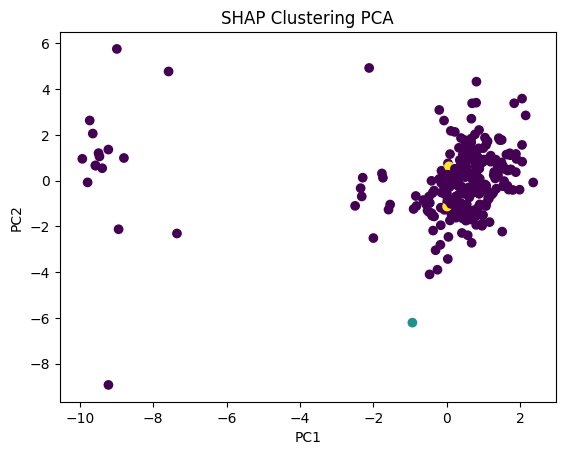

In [107]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(shap_matrix_scaled)

plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap='viridis')
plt.title("SHAP Clustering PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [108]:
# 클러스터별 평균 SHAP
import pandas as pd

shap_df = pd.DataFrame(shap_matrix, columns=X_sample.columns)
shap_df["Cluster"] = clusters

cluster_mean_shap = shap_df.groupby("Cluster").mean().T
print(cluster_mean_shap)

# 클러스터별 원본 변수 평균
X_sample_with_cluster = X_sample.copy()
X_sample_with_cluster["Cluster"] = clusters

cluster_mean_vars = X_sample_with_cluster.groupby("Cluster").mean().T
print(cluster_mean_vars)


Cluster                      0         1         2
YEAR                  0.000000  0.000000  0.000000
AGE                  -5.228960 -5.685705 -6.057397
EDUC                 -0.077910  0.175630 -0.248934
GENDER               -0.001432  0.019116  0.062638
SPHSERVICE           -0.001140 -0.000913 -0.001180
CMPSERVICE           -0.001346  0.001266  0.002004
OPISERVICE           -0.000512  0.003844 -0.000742
RTCSERVICE           -0.000849 -0.006291 -0.003149
IJSSERVICE            0.000470 -0.000052 -0.000113
MH3                   0.001524 -0.002740 -0.006270
EMPLOY                0.050244 -0.012323 -0.032350
VETERAN              -0.004900  0.001304  0.002541
NUMMHS               -0.003715 -0.000069 -0.003596
TRAUSTREFLG           0.000515  0.009454 -0.010643
RACE_2               -0.000068  0.000007 -0.000067
RACE_3                0.001708  0.002813 -0.004035
RACE_4               -0.000071  0.000016  0.000008
RACE_5               -0.000567 -0.011555 -0.010345
RACE_6                0.000904 